# Figures for the Paper

Let's make some figures for the methods section of the paper.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

import numpy as np
import scipy.io
import pickle
import corner
import pandas as pd

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params
from stingray.modeling.gpmodeling import GPResult

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors

datadir = "../data/"
figdir = "../figures/"


INFO[2024-05-29 14:23:45,270]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1716985425.270359       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2024-05-29 14:23:45,271]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-05-29 14:23:45,277]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

## Useful Functions

Here are some useful functions I'm going to need:

In [2]:
def get_max_posterior_parameters(res):
    """
    Returns the optimal parameters for the model based on the NUTS sampling
    """
    max_post_idx = jnp.argmax(res.log_posterior_density)
    map_points = jax.tree_map(lambda x: x[max_post_idx], res.samples)

    return map_points

def plot_posterior_predictive(lc, res, kernel_type, mean_type, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples

    # array for resampled samples
    samples_resampled = {}
    
    all_params = list(res.samples.keys())
    if "pred" in all_params:
        all_params.remove("pred")

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in all_params:
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    print("Resampling done, calculating maximum posterior model ...")
    # split into samples belonging to the kernel, and samples 
    # belonging to the mean function
    kernel_params = stingray.modeling.gpmodeling._get_kernel_params(kernel_type)
    mean_params = stingray.modeling.gpmodeling._get_mean_params(mean_type)

    mean_samples = dict((k, samples_resampled[k]) for k in mean_params)

    maxpost_log = get_max_posterior_parameters(res)

    sk_maxpost_log = dict((k, maxpost_log[k]) for k in kernel_params)
    sm_maxpost_log = dict((k, maxpost_log[k]) for k in mean_params)

    sk_maxpost, sm_maxpost = {}, {}
    for params in kernel_params:
        if params[0:4] == "log_":
            sk_maxpost[params[4:]] = jnp.exp(sk_maxpost_log[params])
        else:
            sk_maxpost[params] = sk_maxpost_log[params]

    for params in mean_params:
        if params[0:4] == "log_":
            sm_maxpost[params[4:]] = jnp.exp(sm_maxpost_log[params])
        else:
            sm_maxpost[params] = sm_maxpost_log[params]
            
    print(mean_type)
    kernel = get_kernel(kernel_type=kernel_type, kernel_params=sk_maxpost)
    mean = get_mean(mean_type=mean_type, mean_params=sm_maxpost)
    
    gp = GaussianProcess(kernel, lc.time, mean_value=mean(lc.time))
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)
    _, cond = gp.condition(lc.counts, tgrid)

    mu = cond.loc + mean(tgrid)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="GP Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = dict((k, mean_samples[k][idx]) for k in mean_params)
        sm = {}
        for params in mean_params:
            if params[0:4] == "log_":
                sm[params[4:]] = jnp.exp(sm_log[params])
            else:
                sm[params] = sm_log[params]

        mean = get_mean(mean_type=mean_type, mean_params=sm)
        mean_vals = mean(tgrid)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(tgrid, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function \n posterior draws")  
        else:
            ax.plot(tgrid, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

def resample_posterior(res, rkey):
    """
    Resample Nested Sampling posterior sample 
    based on the weights to provide unbiased
    posterior samples.

    Parameters
    ----------
    res : jaxns.Results object
        The object with the posterior results of 
        the Nested Sampling run

    rkey : jax.RandomState key
        A random key for reproducibility

    Returns
    -------
    samples_resampled : dict
        A dictionary with the resampled samples
    """
    log_p = res.log_dp_mean #log-prob

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in res.samples.keys():
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    return samples_resampled

## Loading in the data

Let's first load the data for all three instruments.

#### INTEGRAL

In [3]:
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)

lc_int = Lightcurve(barytime[1:], counts[1:])

# LC for wavelets with smaller resolution
lc_int_w = Lightcurve(barytime[1:], counts[1:])
minind = lc_int_w.time.searchsorted(-2.0)
maxind = lc_int_w.time.searchsorted(62.0)
lc_int_w = lc_int_w.truncate(start=minind, stop=maxind, method="index")
lc_int_w = lc_int_w.rebin(0.1)

ps_int = Powerspectrum(lc_int, norm="leahy")
ps_log_int = ps_int.rebin_log()

mintime = barytime[0]
maxtime = barytime[-1]
print(mintime)
print(maxtime)

INFO[2024-05-29 14:23:48,200]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-05-29 14:23:48,261]: Checking if light curve is sorted.
INFO[2024-05-29 14:23:48,330]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation
INFO[2024-05-29 14:23:48,333]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-05-29 14:23:48,334]: Checking if light curve is sorted.
INFO[2024-05-29 14:23:48,334]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


-6.871859666673766
98.12814033332624


#### Fermi/GBM NaI

In [4]:
# read data
data = scipy.io.readsav(datadir+"bn230307656_na_lc_bary.sav")

print(data)
# extract events
barytime = np.array(data["na_times"], dtype=float)
counts = np.array(data["na_counts"], dtype=float)
#lc = Lightcurve.make_lightcurve(barytime, dt=0.05)
lc_nai = Lightcurve(barytime, counts)

# LC for wavelets with smaller resolution
lc_nai_w = Lightcurve(barytime[1:], counts[1:])
minind = lc_nai_w.time.searchsorted(-2.0)
maxind = lc_nai_w.time.searchsorted(62.0)
lc_nai_w = lc_nai_w.truncate(start=minind, stop=maxind, method="index")
lc_nai_w = lc_nai_w.rebin(0.1)

# truncate light curve
minind = lc_nai.time.searchsorted(mintime)
maxind = lc_nai.time.searchsorted(maxtime)
lc_nai = lc_nai.truncate(start=minind, stop=maxind, method="index")

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc_nai.dt * lc_nai.counts
counts_obs_corr = lc_nai.counts / (1. - frac_obs) 


# make light curve and PSD
lc_nai = Lightcurve(lc_nai.time, counts_obs_corr)
ps_nai = Powerspectrum(lc_nai, norm="leahy")
ps_log_nai = ps_nai.rebin_log()

INFO[2024-05-29 14:23:48,563]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-05-29 14:23:48,564]: Checking if light curve is sorted.
INFO[2024-05-29 14:23:48,565]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation
INFO[2024-05-29 14:23:48,568]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-05-29 14:23:48,569]: Checking if light curve is sorted.
INFO[2024-05-29 14:23:48,570]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation
INFO[2024-05-29 14:23:48,587]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-05-29 14:

{'na_times': array([-138.53464363, -138.48464363, -138.43464363, ...,  475.76535637,
        475.81535637,  475.86535637]), 'na_counts': array([37., 52., 54., ..., 46., 43.,  5.]), 'bbtime': 699896631.164607, 'tres': 0.05}


#### Fermi/GBM BGO

In [5]:
# read data
data = scipy.io.readsav(datadir+"bn230307656_b1_lc_bary.sav")

print(data)
# extract events
barytime = np.array(data["b1_times"], dtype=float)
counts = np.array(data["b1_counts"], dtype=float)
#lc = Lightcurve.make_lightcurve(barytime, dt=0.05)
lc_bgo = Lightcurve(barytime, counts)

# LC for wavelets with smaller resolution
lc_bgo_w = Lightcurve(barytime[1:], counts[1:])
minind = lc_bgo_w.time.searchsorted(-2.0)
maxind = lc_bgo_w.time.searchsorted(62.0)
lc_bgo_w = lc_bgo_w.truncate(start=minind, stop=maxind, method="index")
lc_bgo_w = lc_bgo_w.rebin(0.1)

# truncate light curve
minind = lc_bgo.time.searchsorted(mintime)
maxind = lc_bgo.time.searchsorted(maxtime)
lc_bgo = lc_bgo.truncate(start=minind, stop=maxind, method="index")

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc_bgo.dt * lc_bgo.counts
counts_obs_corr = lc_bgo.counts / (1. - frac_obs) 


# make light curve and PSD
lc_bgo = Lightcurve(lc_bgo.time, counts_obs_corr)
ps_bgo = Powerspectrum(lc_bgo, norm="leahy")
ps_log_bgo = ps_bgo.rebin_log()

INFO[2024-05-29 14:23:48,616]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-05-29 14:23:48,617]: Checking if light curve is sorted.
INFO[2024-05-29 14:23:48,617]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation
INFO[2024-05-29 14:23:48,620]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-05-29 14:23:48,621]: Checking if light curve is sorted.
INFO[2024-05-29 14:23:48,621]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation
INFO[2024-05-29 14:23:48,638]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-05-29 14:

{'b1_times': array([-138.53565357, -138.48565357, -138.43565357, ...,  475.76434643,
        475.81434643,  475.86434643]), 'b1_counts': array([50., 47., 37., ..., 46., 51., 14.]), 'bbtime': 699896631.1646451, 'tres': 0.05}


## Plotting all three light curves:

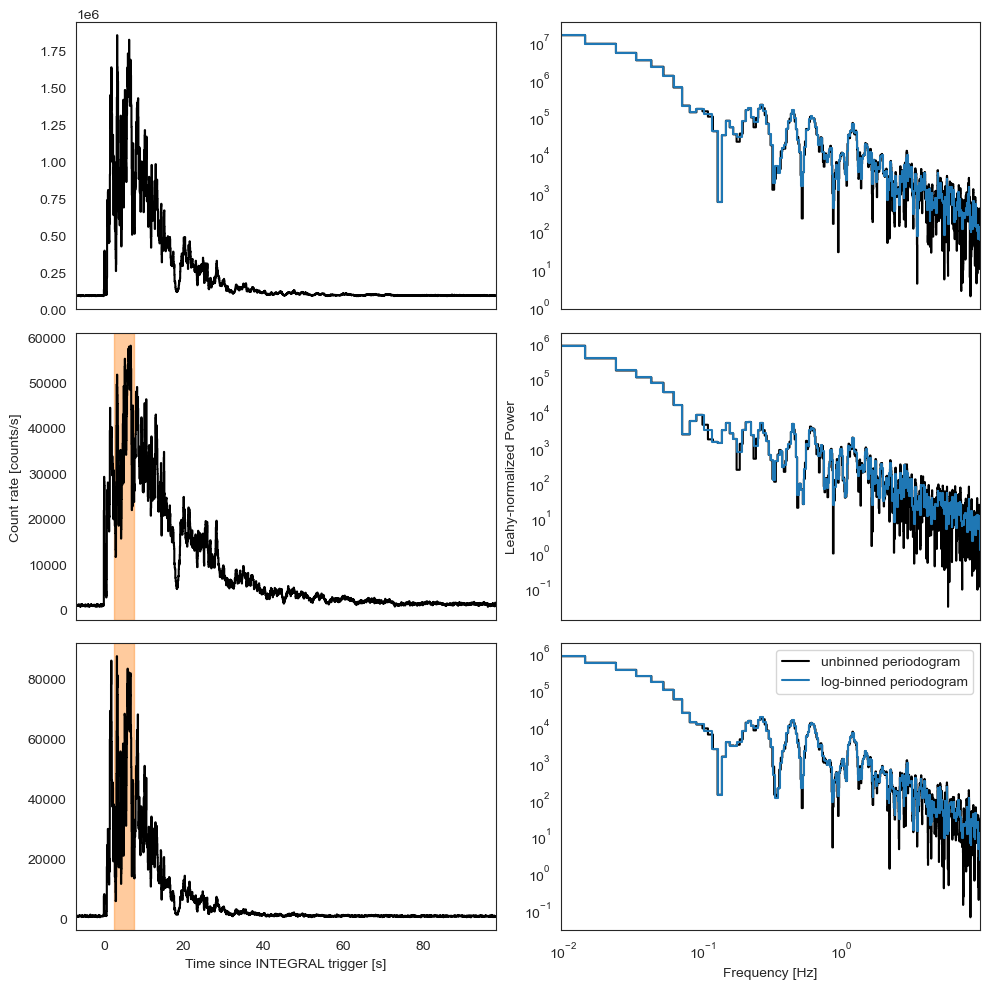

In [12]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes = np.hstack(axes)

axes[0].plot(lc_int.time, lc_int.countrate, ds="steps-mid", color="black")
axes[0].set_xlim(mintime, maxtime)
axes[0].set_xticks([])

axes[1].loglog(ps_int.freq, ps_int.power, ds="steps-mid", color="black")
axes[1].loglog(ps_log_int.freq, ps_log_int.power, ds="steps-mid", color="C0")
axes[1].set_xlim(ps_int.freq[0], ps_int.freq[-1])
axes[1].set_xticks([])

axes[2].plot(lc_nai.time, lc_nai.countrate, ds="steps-mid", color="black")
ylim = axes[2].get_ylim()
rect1 = Rectangle((2.5, ylim[0]), 5.0, ylim[1]-ylim[0], linewidth=1, edgecolor='C1', facecolor='C1', alpha=0.4)
axes[2].add_patch(rect1)
axes[2].set_xlim(mintime, maxtime)
axes[2].set_ylim(ylim)
axes[2].set_xticks([])
axes[2].set_ylabel("Count rate [counts/s]")

axes[3].loglog(ps_nai.freq, ps_nai.power, ds="steps-mid", color="black")
axes[3].loglog(ps_log_nai.freq, ps_log_nai.power, ds="steps-mid", color="C0")
axes[3].set_xlim(ps_nai.freq[0], ps_nai.freq[-1])
axes[3].set_xticks([])
axes[3].set_ylabel("Leahy-normalized Power")

axes[4].plot(lc_bgo.time, lc_bgo.countrate, ds="steps-mid", color="black")
ylim = axes[4].get_ylim()
rect2 = Rectangle((2.5, ylim[0]), 5.0, ylim[1]-ylim[0], linewidth=1, edgecolor='C1', facecolor='C1', alpha=0.4)
axes[4].add_patch(rect2)
axes[4].set_ylim(ylim)

axes[4].set_xlim(mintime, maxtime)
axes[4].set_xlabel("Time since INTEGRAL trigger [s]")

axes[5].loglog(ps_bgo.freq, ps_bgo.power, ds="steps-mid", color="black",label="unbinned periodogram")
axes[5].loglog(ps_log_bgo.freq, ps_log_bgo.power, ds="steps-mid", color="C0", label="log-binned periodogram")
axes[5].set_xlim(ps_bgo.freq[0], ps_bgo.freq[-1])
axes[5].set_xlabel("Frequency [Hz]")
axes[5].legend()

fig.tight_layout()
fig.savefig(figdir+"grb230307a_lc_ps_all.pdf", format="pdf")

## Periodogram Analysis

In [7]:
from stingray import Powerspectrum
from stingray.modeling import PSDPosterior, PSDParEst
from astropy.modeling import models
from stingray.modeling import set_logprior
import scipy.stats
from astropy.modeling.fitting import _fitter_to_model_params


First, the power law model:

In [8]:
# define power law component
pl = models.PowerLaw1D()

# fix x_0 of power law component
pl.x_0.fixed = True

# define constant
c = models.Const1D()

# make compound model
plc = pl + c

# flat prior for the power law index
p_alpha = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors = {}
priors["alpha_0"] = p_alpha
priors["amplitude_0"] = p_amplitude
priors["amplitude_1"] = p_whitenoise

QPO model setup:

In [9]:
# broken power law model
qpoplc = models.PowerLaw1D() + models.Lorentz1D()

# fix x_0 of power law component
qpoplc.x_0_0.fixed = True

# flat prior for the power law indices
p_alpha0 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

p_x0 = lambda x0: ((0.1 <= x0) & (x0 <= 2.5))
p_fwhm = lambda fwhm: ((0.001 <= fwhm) & (fwhm <= 1.0))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors_qpopl = {"amplitude_0": p_amplitude,
                "alpha_0": p_alpha0,
                "amplitude_1": p_amplitude,
                "x_0_1": p_x0,
                "fwhm_1": p_fwhm,
                }

Two QPO Model:

In [10]:
# broken power law model
two_qpoplc = models.PowerLaw1D() + models.Lorentz1D() + models.Lorentz1D()

# fix x_0 of power law component
two_qpoplc.x_0_0.fixed = True

# flat prior for the power law indices
p_alpha0 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

p_x0_1 = lambda x0: ((0.1 <= x0) & (x0 <= 2.0))
p_x0_2 = lambda x0: ((2.0 <= x0) & (x0 <= 5.0))

p_fwhm_1 = lambda fwhm: ((0.001 <= fwhm) & (fwhm <= 1.0))
p_fwhm_2 = lambda fwhm: ((0.01 <= fwhm) & (fwhm <= 2.5))


priors_two_qpopl = {"amplitude_0": p_amplitude,
                "alpha_0": p_alpha0,
                "amplitude_1": p_amplitude,
                "x_0_1": p_x0_1,
                "fwhm_1": p_fwhm_1,
                'amplitude_2':p_amplitude,
                'x_0_2':p_x0_2,
                'fwhm_2':p_fwhm_2
                }

#### INTEGRAL

In [11]:
lpost_int = PSDPosterior(ps_int.freq, ps_int.power, plc, m=ps_int.m)
lpost_qpo_int = PSDPosterior(ps_int.freq, ps_int.power, qpoplc, m=ps_int.m)
lpost_twoqpo_int = PSDPosterior(ps_int.freq, ps_int.power, two_qpoplc, m=ps_int.m)

lpost_int.logprior = set_logprior(lpost_int, priors)
lpost_qpo_int.logprior = set_logprior(lpost_qpo_int, priors_qpopl)
lpost_twoqpo_int.logprior = set_logprior(lpost_qpo_int, priors_two_qpopl)

test_pars = [1e4, 1.5, 2.0]
test_pars_qpoplc = [1e4, 1.5, 5e4, 1.2, 0.1]
test_pars_two_qpoplc = [1e4, 1.5, 5e4, 1.2, 0.1, 1e4, 2.9, 0.5]

_fitter_to_model_params(plc, test_pars)


Posterior samples:

In [12]:
samples_int = np.loadtxt(datadir + "grb230307a_integral_pl_sample.txt")
samples_qpo_int = np.loadtxt(datadir + "grb230307a_integral_qpopl_sample.txt")
samples_twoqpo_int = np.loadtxt(datadir + "grb230307a_integral_twoqpopl_sample.txt")

Simulated likelihood ratios:

In [13]:
lrt_sim_int = np.loadtxt(datadir + "grb230307a_integral_qpo_tsim_lrt.txt")
lrt_twoqpo_sim_int = np.loadtxt(datadir + "grb230307a_integral_twoqpo_tsim_lrt.txt")

Compute likelihood ratio of observation:

In [14]:
parest_int = PSDParEst(ps_int, fitmethod='bfgs', max_post=False)
lrt_int, plc_opt_int, qpoplc_opt_int = parest_int.compute_lrt(lpost_int, test_pars, lpost_qpo_int, test_pars_qpoplc)
lrt_twoqpo_int, qpoplc_opt_int, twoqpoplc_opt_int = parest_int.compute_lrt(lpost_qpo_int, test_pars_qpoplc, 
                                                                           lpost_twoqpo_int, test_pars_two_qpoplc)

print(qpoplc_opt_int.p_opt)
print(f"Likelihood ratio QPOPL/PL: {lrt_int}")
print(f"Likelihood ratio 2QPOPL/QPOPL: {lrt_twoqpo_int}")



[1.19724760e+04 1.64811582e+00 4.99916200e+04 1.21646853e+00
 8.33234737e-02]
Likelihood ratio QPOPL/PL: 24.666741259272385
Likelihood ratio 2QPOPL/QPOPL: 38.818918448963814


In [15]:
import matplotlib.gridspec as gridspec

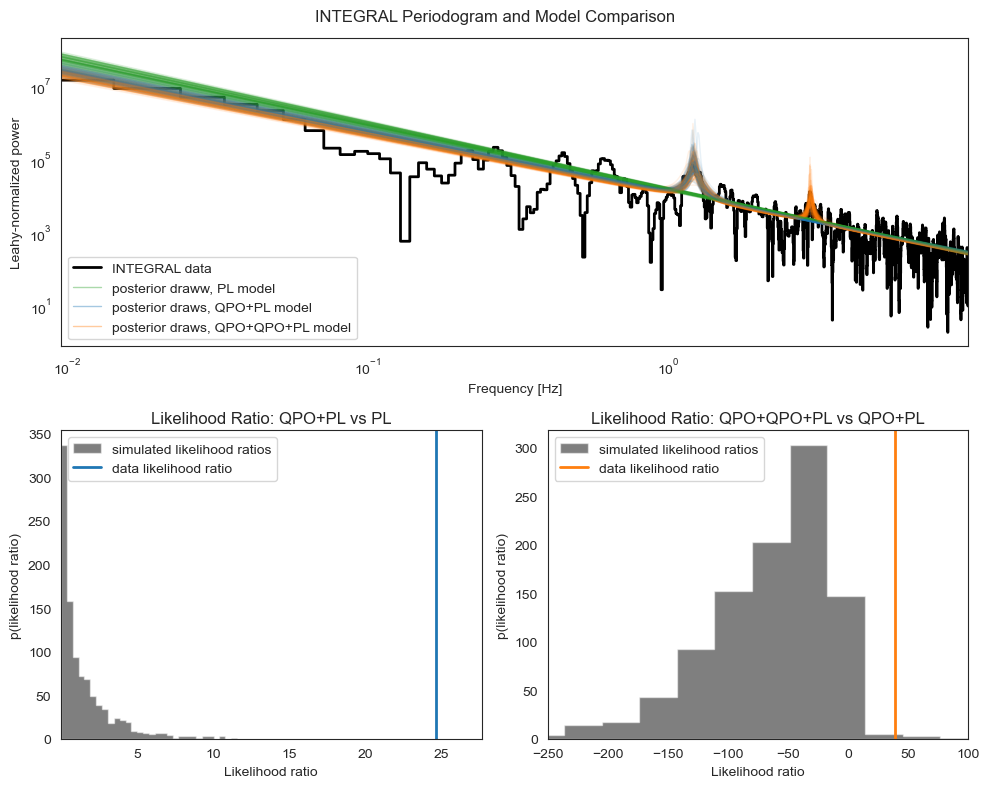

In [16]:
idx = np.random.choice(np.arange(samples_int.shape[0]), size=100, replace=False)


#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={"width_ratios":[2,1]})
fig = plt.figure(tight_layout=True, figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, :])

ax1.loglog(ps_int.freq, ps_int.power, lw=2, color="black", ds="steps-mid",
          label="INTEGRAL data")


for k, i in enumerate(idx):
    _fitter_to_model_params(plc, samples_int[i])
    _fitter_to_model_params(qpoplc, samples_qpo_int[i])
    _fitter_to_model_params(two_qpoplc, samples_twoqpo_int[i])
    if k ==  0:
        ax1.plot(ps_int.freq, plc(ps_int.freq) , lw=1, color="C2", alpha=0.4,
                label="posterior draww, PL model")
        ax1.plot(ps_int.freq, qpoplc(ps_int.freq), lw=1, color="C0", alpha=0.4,
                label="posterior draws, QPO+PL model")        
        ax1.plot(ps_int.freq, two_qpoplc(ps_int.freq), lw=1, color="C1", alpha=0.4,
                label="posterior draws, QPO+QPO+PL model")
    ax1.plot(ps_int.freq, plc(ps_int.freq) , lw=1, color="C2", alpha=0.1)
    ax1.plot(ps_int.freq, qpoplc(ps_int.freq), lw=1, color="C0", alpha=0.1)
    ax1.plot(ps_int.freq, two_qpoplc(ps_int.freq), lw=1, color="C1", alpha=0.1)
    
ax1.legend()
ax1.set_xlim(ps_int.freq[0], ps_int.freq[-1])
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Leahy-normalized power")


ax2 = fig.add_subplot(gs[1, 0])

ax2.hist(lrt_sim_int, bins=30, histtype="stepfilled", color="black", alpha=0.5, label="simulated likelihood ratios")
ax2.axvline(lrt_int, lw=2, color="C0", label="data likelihood ratio")
ax2.set_xlim(np.min(lrt_sim_int), lrt_int + 3)
ax2.legend()
ax2.set_xlabel("Likelihood ratio")
ax2.set_ylabel("p(likelihood ratio)")
ax2.set_title("Likelihood Ratio: QPO+PL vs PL")

ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(lrt_twoqpo_sim_int, bins=30, histtype="stepfilled", color="black", alpha=0.5, label="simulated likelihood ratios")
ax3.axvline(lrt_twoqpo_int, lw=2, color="C1", label="data likelihood ratio")
#ax3.set_xlim(np.min(lrt_sim_int), lrt_int + 3)
ax3.set_xlim(-250, 100)
ax3.legend()
ax3.set_xlabel("Likelihood ratio")
ax3.set_ylabel("p(likelihood ratio)")
ax3.set_title("Likelihood Ratio: QPO+QPO+PL vs QPO+PL")


fig.suptitle("INTEGRAL Periodogram and Model Comparison")

fig.tight_layout()
fig.savefig(figdir + "grb230307a_integral_periodogram_lrt.pdf", format="pdf")

#### Fermi/NaI Version of this plot:

In [17]:
lpost_nai = PSDPosterior(ps_nai.freq, ps_nai.power, plc, m=ps_nai.m)
lpost_qpo_nai = PSDPosterior(ps_nai.freq, ps_nai.power, qpoplc, m=ps_nai.m)
lpost_twoqpo_nai = PSDPosterior(ps_nai.freq, ps_nai.power, two_qpoplc, m=ps_nai.m)

lpost_nai.logprior = set_logprior(lpost_nai, priors)
lpost_qpo_nai.logprior = set_logprior(lpost_qpo_nai, priors_qpopl)
lpost_twoqpo_nai.logprior = set_logprior(lpost_qpo_nai, priors_two_qpopl)

test_pars = [1e4, 1.5, 2.0]
test_pars_qpoplc = [300, 1.5, 2000, 1.2, 0.15]
test_pars_two_qpoplc = [370, 1.62, 469, 1.242, 0.453, 400, 2.9, 0.5]

print("log-prior: " + str(lpost_nai.logprior(test_pars)))
print("log-likelihood: " + str(lpost_nai.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost_nai(test_pars)))

#_fitter_to_model_params(plc, test_pars)


log-prior: 1.383646559789373
log-likelihood: -7642.801785668989
log-posterior: -7641.4181391092


Posterior samples:

In [18]:
samples_nai = np.loadtxt(datadir + "grb230307a_fermi_nai_pl_sample.txt")
samples_qpo_nai = np.loadtxt(datadir + "grb230307a_fermi_nai_qpopl_sample.txt")
samples_twoqpo_nai = np.loadtxt(datadir + "grb230307a_fermi_nai_twoqpopl_sample.txt")

Simulated likelihood ratios:

In [19]:
lrt_sim_nai = np.loadtxt(datadir + "grb230307a_fermi_nai_qpo_tsim_lrt.txt")
lrt_twoqpo_sim_nai = np.loadtxt(datadir + "grb230307a_fermi_nai_twoqpo_tsim_lrt.txt")

Compute likelihood ratio of observation:

In [20]:
parest_nai = PSDParEst(ps_nai, fitmethod='bfgs', max_post=False)
lrt_nai, plc_opt_nai, qpoplc_opt_nai = parest_nai.compute_lrt(lpost_nai, test_pars, lpost_qpo_nai, test_pars_qpoplc)
lrt_twoqpo_nai, qpoplc_opt_nai, twoqpoplc_opt_nai = parest_nai.compute_lrt(lpost_qpo_nai, test_pars_qpoplc, 
                                                                           lpost_twoqpo_nai, test_pars_two_qpoplc)

print(twoqpoplc_opt_nai.p_opt)
print(f"Likelihood ratio QPOPL/PL: {lrt_nai}")
print(f"Likelihood ratio 2QPOPL/QPOPL: {lrt_twoqpo_nai}")


[3.15378984e+02 1.61808768e+00 5.33007975e+02 1.23565961e+00
 2.95867005e-01 1.41380481e+02 2.93012541e+00 1.16414239e-01]
Likelihood ratio QPOPL/PL: 19.705506941812928
Likelihood ratio 2QPOPL/QPOPL: 24.436143787297624


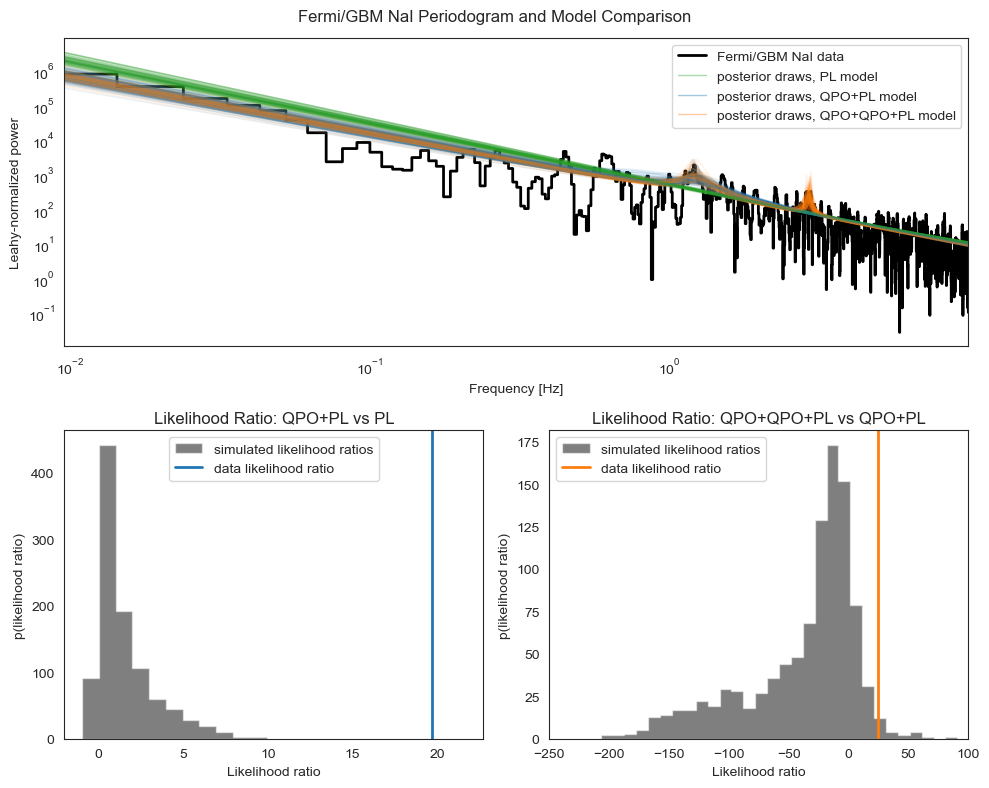

In [21]:
idx = np.random.choice(np.arange(samples_nai.shape[0]), size=100, replace=False)


#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={"width_ratios":[2,1]})
fig = plt.figure(tight_layout=True, figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, :])

ax1.loglog(ps_nai.freq, ps_nai.power, lw=2, color="black", ds="steps-mid",
          label="Fermi/GBM NaI data")


for k, i in enumerate(idx):
    _fitter_to_model_params(plc, samples_nai[i])
    _fitter_to_model_params(qpoplc, samples_qpo_nai[i])
    _fitter_to_model_params(two_qpoplc, samples_twoqpo_nai[i])
    if k ==  0:
        ax1.plot(ps_nai.freq, plc(ps_nai.freq) , lw=1, color="C2", alpha=0.4,
                label="posterior draws, PL model")
        ax1.plot(ps_nai.freq, qpoplc(ps_nai.freq), lw=1, color="C0", alpha=0.4,
                label="posterior draws, QPO+PL model")        
        ax1.plot(ps_nai.freq, two_qpoplc(ps_nai.freq), lw=1, color="C1", alpha=0.4,
                label="posterior draws, QPO+QPO+PL model")
    ax1.plot(ps_nai.freq, plc(ps_nai.freq) , lw=1, color="C2", alpha=0.1)
    ax1.plot(ps_nai.freq, qpoplc(ps_nai.freq), lw=1, color="C0", alpha=0.1)
    ax1.plot(ps_nai.freq, two_qpoplc(ps_nai.freq), lw=1, color="C1", alpha=0.1)
    
ax1.legend()
ax1.set_xlim(ps_nai.freq[0], ps_nai.freq[-1])
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Leahy-normalized power")


ax2 = fig.add_subplot(gs[1, 0])

ax2.hist(lrt_sim_nai, bins=30, histtype="stepfilled", color="black", alpha=0.5, label="simulated likelihood ratios")
ax2.axvline(lrt_nai, lw=2, color="C0", label="data likelihood ratio")
ax2.set_xlim(-2, lrt_nai + 3)
ax2.legend()
ax2.set_xlabel("Likelihood ratio")
ax2.set_ylabel("p(likelihood ratio)")
ax2.set_title("Likelihood Ratio: QPO+PL vs PL")

ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(lrt_twoqpo_sim_nai, bins=30, histtype="stepfilled", color="black", alpha=0.5, label="simulated likelihood ratios")
ax3.axvline(lrt_twoqpo_nai, lw=2, color="C1", label="data likelihood ratio")
#ax3.set_xlim(np.min(lrt_sim_nai), lrt_nai + 3)
ax3.set_xlim(-250, 100)
ax3.legend()
ax3.set_xlabel("Likelihood ratio")
ax3.set_ylabel("p(likelihood ratio)")
ax3.set_title("Likelihood Ratio: QPO+QPO+PL vs QPO+PL")


fig.suptitle("Fermi/GBM NaI Periodogram and Model Comparison")

fig.tight_layout()
fig.savefig(figdir + "grb230307a_fermi_nai_periodogram_lrt.pdf", format="pdf")

#### Fermi/BGO:

In [22]:
lpost_bgo = PSDPosterior(ps_bgo.freq, ps_bgo.power, plc, m=ps_bgo.m)
lpost_qpo_bgo = PSDPosterior(ps_bgo.freq, ps_bgo.power, qpoplc, m=ps_bgo.m)
lpost_twoqpo_bgo = PSDPosterior(ps_bgo.freq, ps_bgo.power, two_qpoplc, m=ps_bgo.m)

lpost_bgo.logprior = set_logprior(lpost_bgo, priors)
lpost_qpo_bgo.logprior = set_logprior(lpost_qpo_bgo, priors_qpopl)
lpost_twoqpo_bgo.logprior = set_logprior(lpost_qpo_bgo, priors_two_qpopl)


test_pars = [1e4, 1.5, 2.0]
test_pars_qpoplc = [1500, 1.7, 6000, 1.2, 0.005]
test_pars_two_qpoplc = [1458, 1.72, 6016, 1.21, 0.087, 5000, 2.9, 0.01]


print("log-prior: " + str(lpost_bgo.logprior(test_pars)))
print("log-likelihood: " + str(lpost_bgo.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost_bgo(test_pars)))

_fitter_to_model_params(plc, test_pars)

parest_bgo = PSDParEst(ps_bgo, fitmethod='bfgs', max_post=False)
lrt_bgo, plc_opt_bgo, qpoplc_opt_bgo = parest_bgo.compute_lrt(lpost_bgo, test_pars, lpost_qpo_bgo, test_pars_qpoplc)
print(qpoplc_opt_bgo.p_opt)
print(f"Likelihood ratio: {lrt_bgo}")


log-prior: 1.383646559789373
log-likelihood: -7718.517997758737
log-posterior: -7717.134351198947
[1.24603195e+03 1.72725774e+00 5.98878121e+03 1.21120554e+00
 7.86032108e-02]
Likelihood ratio: 23.28949607399045


In [23]:
samples_bgo = np.loadtxt(datadir + "grb230307a_fermi_bgo_pl_sample.txt")
samples_qpo_bgo = np.loadtxt(datadir + "grb230307a_fermi_bgo_qpopl_sample.txt")
samples_twoqpo_bgo = np.loadtxt(datadir + "grb230307a_fermi_bgo_twoqpopl_sample.txt")

lrt_sim_bgo = np.loadtxt(datadir + "grb230307a_fermi_bgo_qpo_tsim_lrt.txt")
lrt_twoqpo_sim_bgo = np.loadtxt(datadir + "grb230307a_fermi_bgo_twoqpo_tsim_lrt.txt")

In [24]:
parest_bgo = PSDParEst(ps_bgo, fitmethod='bfgs', max_post=False)
lrt_bgo, plc_opt_bgo, qpoplc_opt_bgo = parest_bgo.compute_lrt(lpost_bgo, test_pars, lpost_qpo_bgo, test_pars_qpoplc)
lrt_twoqpo_bgo, qpoplc_opt_bgo, twoqpoplc_opt_bgo = parest_bgo.compute_lrt(lpost_qpo_bgo, test_pars_qpoplc, 
                                                                           lpost_twoqpo_bgo, test_pars_two_qpoplc)

print(twoqpoplc_opt_bgo.p_opt)
print(f"Likelihood ratio QPOPL/PL: {lrt_bgo}")
print(f"Likelihood ratio 2QPOPL/QPOPL: {lrt_twoqpo_bgo}")


[ 1.17499339e+03  1.71296862e+00  6.01906631e+03  1.21178764e+00
  8.15384153e-02  4.99673469e+03  2.97736197e+00 -1.59157087e-02]
Likelihood ratio QPOPL/PL: 23.28922924516337
Likelihood ratio 2QPOPL/QPOPL: 32.255181392349186


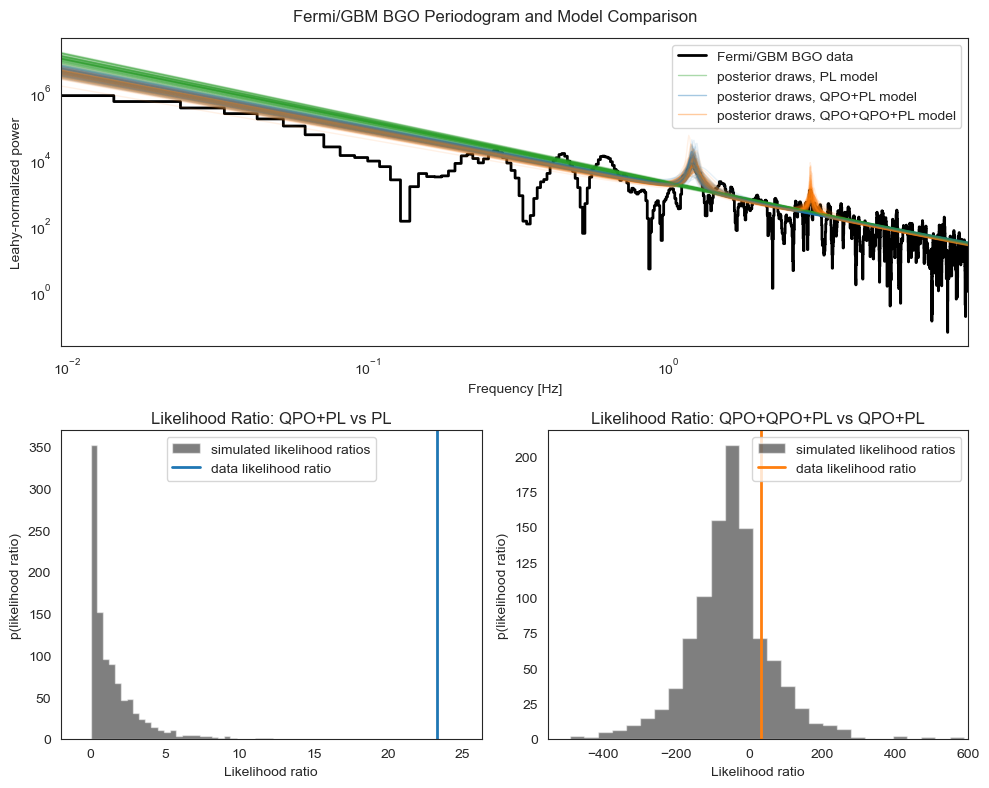

In [25]:
idx = np.random.choice(np.arange(samples_bgo.shape[0]), size=100, replace=False)


#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={"width_ratios":[2,1]})
fig = plt.figure(tight_layout=True, figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, :])

ax1.loglog(ps_bgo.freq, ps_bgo.power, lw=2, color="black", ds="steps-mid",
          label="Fermi/GBM BGO data")


for k, i in enumerate(idx):
    _fitter_to_model_params(plc, samples_bgo[i])
    _fitter_to_model_params(qpoplc, samples_qpo_bgo[i])
    _fitter_to_model_params(two_qpoplc, samples_twoqpo_bgo[i])
    if k ==  0:
        ax1.plot(ps_bgo.freq, plc(ps_bgo.freq) , lw=1, color="C2", alpha=0.4,
                label="posterior draws, PL model")
        ax1.plot(ps_bgo.freq, qpoplc(ps_bgo.freq), lw=1, color="C0", alpha=0.4,
                label="posterior draws, QPO+PL model")        
        ax1.plot(ps_bgo.freq, two_qpoplc(ps_bgo.freq), lw=1, color="C1", alpha=0.4,
                label="posterior draws, QPO+QPO+PL model")
    ax1.plot(ps_bgo.freq, plc(ps_bgo.freq) , lw=1, color="C2", alpha=0.1)
    ax1.plot(ps_bgo.freq, qpoplc(ps_bgo.freq), lw=1, color="C0", alpha=0.1)
    ax1.plot(ps_bgo.freq, two_qpoplc(ps_bgo.freq), lw=1, color="C1", alpha=0.1)
    
ax1.legend()
ax1.set_xlim(ps_bgo.freq[0], ps_bgo.freq[-1])
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Leahy-normalized power")


ax2 = fig.add_subplot(gs[1, 0])

ax2.hist(lrt_sim_bgo, bins=30, histtype="stepfilled", color="black", alpha=0.5, label="simulated likelihood ratios")
ax2.axvline(lrt_bgo, lw=2, color="C0", label="data likelihood ratio")
ax2.set_xlim(-2, lrt_bgo + 3)
ax2.legend()
ax2.set_xlabel("Likelihood ratio")
ax2.set_ylabel("p(likelihood ratio)")
ax2.set_title("Likelihood Ratio: QPO+PL vs PL")

ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(lrt_twoqpo_sim_bgo, bins=30, histtype="stepfilled", color="black", alpha=0.5, label="simulated likelihood ratios")
ax3.axvline(lrt_twoqpo_bgo, lw=2, color="C1", label="data likelihood ratio")
#ax3.set_xlim(np.min(lrt_sim_bgo), lrt_bgo + 3)
ax3.set_xlim(-550, 600)
ax3.legend()
ax3.set_xlabel("Likelihood ratio")
ax3.set_ylabel("p(likelihood ratio)")
ax3.set_title("Likelihood Ratio: QPO+QPO+PL vs QPO+PL")


fig.suptitle("Fermi/GBM BGO Periodogram and Model Comparison")

fig.tight_layout()
fig.savefig(figdir + "grb230307a_fermi_bgo_periodogram_lrt.pdf", format="pdf")

##  Wavelet Analysis

Let's first setup the wavelet analysis:

In [38]:
import pywt
wavlist = pywt.wavelist(kind='continuous')

dt = lc_int_w.dt
fmax = 1.0/dt
freq_low = 0.2
freq_high = 5.0
freq_steps = 0.04

frequencies = np.arange(freq_low, freq_high, freq_steps)[::-1]/fmax
wavelet = "cmor10.0-1.5"

scales = pywt.frequency2scale(wavelet, frequencies)

INTEGRAL:

In [39]:
ca_int, cd_int = pywt.cwt(lc_int_w.counts, scales[::-1], wavelet)
X_int, Y_int = np.meshgrid(lc_int_w.time,cd_int*fmax)

# wavelet power
pw_int = np.abs(ca_int)**2.

# load percentiles:
wperc_int = np.load(datadir + "grb230307a_intergral_cmor10.0-1.5_percentiles.npy")

Fermi/NaI:

In [40]:
ca_nai, cd_nai = pywt.cwt(lc_nai_w.counts, scales[::-1], wavelet)
X_nai, Y_nai = np.meshgrid(lc_nai_w.time,cd_nai*fmax)

# wavelet power
pw_nai = np.abs(ca_nai)**2.

# load percentiles:
wperc_nai = np.load(datadir + "grb230307a_fermi_nai_cmor10.0-1.5_percentiles.npy")

Fermi/BGO:

In [42]:
ca_bgo, cd_bgo = pywt.cwt(lc_bgo_w.counts, scales[::-1], wavelet)

# wavelet power
pw_bgo = np.abs(ca_bgo)**2.

# load percentiles:
wperc_bgo = np.load(datadir + "grb230307a_fermi_bgo_cmor10.0-1.5_percentiles.npy")

In [43]:
from scipy.ndimage.filters import gaussian_filter

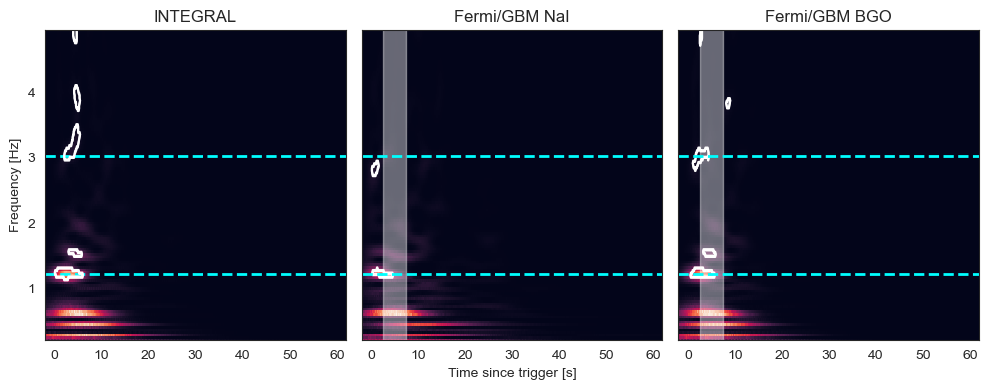

In [80]:
percentile_idx = -1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True)

ax1.pcolormesh(X_int, Y_int, pw_int)
ax1.set_ylabel("Frequency [Hz]")
ax1.set_title("INTEGRAL")
ax1.axhline(1./0.82, lw=2, color="cyan", ls="dashed")
ax1.axhline(1/0.33, lw=2, color="cyan", ls="dashed")

wmask_int = (pw_int > wperc_int[percentile_idx,:,:])
ax1.contour(X_int, Y_int,   gaussian_filter(wmask_int, sigma=0.28, order=0), 1, 
            colors="white", interpolation="gaussian")


ax2.pcolormesh(X_nai, Y_nai, pw_nai)
wmask_nai = (pw_nai > wperc_nai[percentile_idx,:,:])
ax2.contour(X_nai, Y_nai,   gaussian_filter(wmask_nai, sigma=0.2, order=0), 1, 
            colors="white", interpolation="gaussian")
rect = Rectangle((2.5, 0.0), 5.0, 5.0, linewidth=1, edgecolor='w', facecolor='w', alpha=0.4)
ax2.add_patch(rect)

ax2.axhline(1./0.82, lw=2, color="cyan", ls="dashed")
ax2.axhline(1/0.33, lw=2, color="cyan", ls="dashed")


ax2.set_xlabel("Time since trigger [s]")
ax2.set_title("Fermi/GBM NaI")

ax3.pcolormesh(X_nai, Y_nai, pw_bgo)
ax3.set_title("Fermi/GBM BGO")
wmask_bgo = (pw_bgo > wperc_bgo[percentile_idx,:,:])
ax3.contour(X_nai, Y_nai,   gaussian_filter(wmask_bgo, sigma=0.2, order=0), 1, 
            colors="white", interpolation="gaussian")
rect = Rectangle((2.5, 0.0), 5.0, 5.0, linewidth=1, edgecolor='w', facecolor='w', alpha=0.4)
ax3.add_patch(rect)

ax3.axhline(1./0.82, lw=2, color="cyan", ls="dashed")
ax3.axhline(1/0.33, lw=2, color="cyan", ls="dashed")
ax3.set_ylim(np.min(Y_int), np.max(Y_int))
fig.tight_layout()
fig.savefig(figdir + "grb230307a_wavelets_combined.png", format="png")

In [45]:
w_psd_int = np.loadtxt(datadir + "grb230307a_integral_cmor10.0-1.5_w_psd.dat")
w_psd_sim_int = np.loadtxt(datadir + "grb230307a_integral_cmor10.0-1.5_w_psd_sim.dat")
w_psd_perc_int = np.loadtxt(datadir + "grb230307a_integral_cmor10.0-1.5_w_psd_percentiles.dat")

w_psd_nai = np.loadtxt(datadir + "grb230307a_fermi_nai_cmor10.0-1.5_w_psd.dat")
w_psd_sim_nai = np.loadtxt(datadir + "grb230307a_fermi_nai_cmor10.0-1.5_w_psd_sim.dat")
w_psd_perc_nai = np.loadtxt(datadir + "grb230307a_fermi_nai_cmor10.0-1.5_w_psd_percentiles.dat")

w_psd_bgo = np.loadtxt(datadir + "grb230307a_fermi_bgo_cmor10.0-1.5_w_psd.dat")
w_psd_sim_bgo = np.loadtxt(datadir + "grb230307a_fermi_bgo_cmor10.0-1.5_w_psd_sim.dat")
w_psd_perc_bgo = np.loadtxt(datadir + "grb230307a_fermi_bgo_cmor10.0-1.5_w_psd_percentiles.dat")

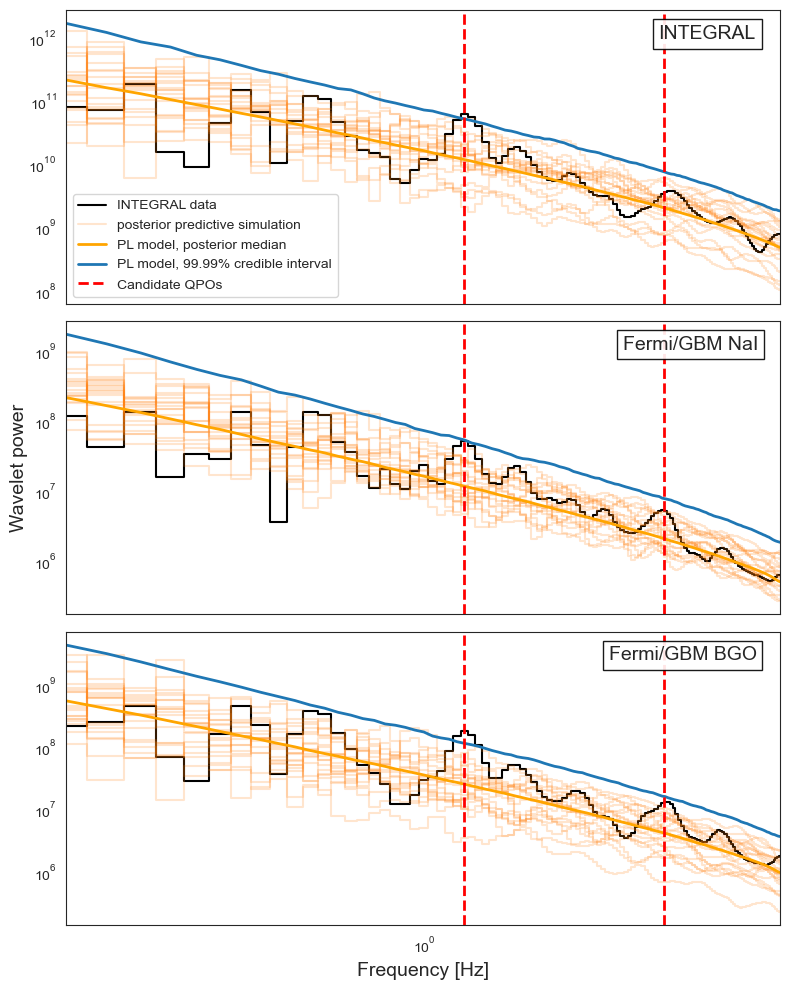

In [75]:
idx_all = np.random.choice(np.arange(w_psd_int.shape[0], dtype=int), size=20, replace=False)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,10), sharex=True)

props = dict(facecolor='white', alpha=0.9, boxstyle="square", edgecolor="black")

fontsize = 14
f = cd_int*fmax
ax1.loglog(f, w_psd_int, color="black", ds="steps-mid", label="INTEGRAL data")

for i, idx in enumerate(idx_all):
    if i == 0:
        ax1.loglog(f, w_psd_sim_int[idx,:], color="C1", alpha=0.2, 
                   ds="steps-mid", label="posterior predictive simulation")
    else:
        ax1.loglog(f, w_psd_sim_int[idx,:], color="C1", alpha=0.2, ds="steps-mid")

ax1.loglog(f, w_psd_perc_int[0,:], lw=2, color="orange", label="PL model, posterior median")
ax1.loglog(f, w_psd_perc_int[-2,:], lw=2, color="C0", label="PL model, 99.99% credible interval")
ax1.axvline(1.2, lw=2, color="red", ls="dashed", label = "Candidate QPOs")
ax1.axvline(2.94, lw=2, color="red", ls="dashed")
# place a text box in upper left in axes coords
ax1.text(0.83, 0.95, "INTEGRAL", transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, )

ax1.set_xlim(f[0], f[-1])
ax1.legend(loc="lower left")

# NAI DATA
ax2.loglog(f, w_psd_nai, color="black", ds="steps-mid", label="Fermi/GBM BGO data")

for i in idx_all:
    ax2.loglog(f, w_psd_sim_nai[i,:], color="C1", alpha=0.2, ds="steps-mid")
    
ax2.loglog(f, w_psd_perc_nai[0,:], lw=2, color="orange", label="PL model, posterior median")
ax2.loglog(f, w_psd_perc_nai[-2,:], lw=2, color="C0", label="PL model, 99.7% credible interval")
ax2.axvline(1.2, lw=2, color="red", ls="dashed", label = "Candidate QPOs")
ax2.axvline(2.94, lw=2, color="red", ls="dashed")
ax2.set_xlim(f[0], f[-1])
ax2.set_ylabel("Wavelet power", fontdict={"size":fontsize})
ax2.text(0.78, 0.95, "Fermi/GBM NaI", transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, )


# BGO DATA
ax3.loglog(f, w_psd_bgo, color="black", ds="steps-mid", label="Fermi/GBM BGO data")

for i, idx in enumerate(idx_all):
    if i == 0:
        ax3.loglog(f, w_psd_sim_bgo[idx,:], color="C1", alpha=0.2, 
                   ds="steps-mid", label="posterior predictive simulation")
    else:
        ax3.loglog(f, w_psd_sim_bgo[idx,:], color="C1", alpha=0.2, ds="steps-mid")


ax3.loglog(f, w_psd_perc_bgo[0,:], lw=2, color="orange", label="PL model, posterior median")
ax3.loglog(f, w_psd_perc_bgo[-2,:], lw=2, color="C0", label="PL model, 99.99% credible interval")
ax3.axvline(1.2, lw=2, color="red", ls="dashed", label = "Candidate QPOs")
ax3.axvline(2.94, lw=2, color="red", ls="dashed")
#ax3.legend()
ax3.set_xlim(f[0], f[-1])
ax3.set_xlabel("Frequency [Hz]", fontdict={"size":fontsize})
ax3.text(0.76, 0.95, "Fermi/GBM BGO", transform=ax3.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, )

fig.tight_layout()
fig.savefig(figdir + "grb230307a_w_psd_combined.pdf", format="pdf")

## INTEGRAL

Some figures about the INTEGRAL data.

First, let's read in the data:

In [ ]:
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)
mean_bkg = np.mean(counts[-100:])

lc = Lightcurve(barytime, counts-mean_bkg)
minind = lc.time.searchsorted(0.0)
maxind = lc.time.searchsorted(60.0)
lc = lc.truncate(start=minind, stop=maxind, method="index")
ps = Powerspectrum(lc, norm="leahy")

### Posterior (Predictive) Plots for the INTEGRAL observation

In [ ]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

times = lc.time
counts = lc.counts

In [ ]:
with open(datadir+"intregal_drw_res.pkl", "rb") as f:
    res_rn = pickle.load(f)

In [ ]:
samples_rn = resample_posterior(res_rn, rkey=random.PRNGKey(1342))

In [ ]:
df_rn = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_rn["log_A"],
                      r"$t_0$": samples_rn["t0"],
                      r"$\log(\tau_\mathrm{rise})$":samples_rn["log_sig1"],
                      r"$\log(\tau_\mathrm{fall})$": samples_rn["log_sig2"],
                      r"$\log(A_{\mathrm{rn}})$": samples_rn["log_arn"],
                      r"$\log(c_\mathrm{rn})$": samples_rn["log_crn"]}
)

In [ ]:
sns.pairplot(df_rn, corner=True, diag_kind="hist", kind="kde", height=1.5)
plt.savefig(f"{figdir}integral_drw_corner.pdf", format="pdf")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, res_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

fig.tight_layout()

fig.savefig(f"{figdir}integral_drw_postpred.pdf", format="pdf")

Let's do the same for the QPO data:

In [ ]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

with open(datadir+"intregal_drw_qpo_res.pkl", "rb") as f:
    res_qpo = pickle.load(f)

In [ ]:
samples_qpo = resample_posterior(res_qpo, rkey=random.PRNGKey(135))

In [ ]:
mask = samples_qpo["log_freq"] > -0.5

In [ ]:
keys = ["log_A", "t0", "log_sig1", "log_sig2", 
        "log_arn", "log_crn", "log_freq", "log_aqpo","log_cqpo"]


In [ ]:
df_qpo = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_qpo["log_A"][mask],
                      r"$t_0$": samples_qpo["t0"][mask],
                      r"$\log(\tau_\mathrm{rise})$":samples_qpo["log_sig1"][mask],
                      r"$\log(\tau_\mathrm{fall})$": samples_qpo["log_sig2"][mask],
                      r"$\log(A_{\mathrm{rn}})$": samples_qpo["log_arn"][mask],
                      r"$\log(c_\mathrm{rn})$": samples_qpo["log_crn"][mask],
                      r"$\log(\nu_c)$":samples_qpo["log_freq"][mask],
                      r"$\log(A_\mathrm{QPO})$":samples_qpo["log_aqpo"][mask],
                      r"$\log(c_\mathrm{QPO})$": samples_qpo["log_cqpo"][mask]}
)

In [ ]:
var_names = np.array(df_qpo.columns)
sample_array = np.array([samples_qpo[v][mask] for v in keys])

In [ ]:
import corner

In [ ]:
fig = plt.figure(figsize=(12,12))
fig = corner.corner(sample_array.T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=False,
              labels=var_names, fig=fig);
plt.savefig(f"{figdir}integral_qpo_corner.pdf", format="pdf")

In [ ]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10,4), width_ratios=[1.8, 1])


ax2 = plot_posterior_predictive(lc, res_qpo, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=ax2, rkey=None)

ax2.set_xlim(lc.time[0], lc.time[-1])
ax2.set_xlabel("Barycentered time since trigger [s]")
ax2.set_ylabel("Counts per 0.05s bin")
ax2.set_ylim(-10, 90000)
ax2.set_title("Skew-Gaussian + DRW + QPO")

period = 1./np.exp(samples_qpo["log_freq"])
histrange = (0.75, 0.9)

ax3.hist(period, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", range=histrange, density=True);
ax3.set_xlabel("Period [s]")
ax3.set_ylabel("Probability Density")

perc = np.percentile(period, [50-(68.5/2), 50, 50+(68.5/2)])
err = [perc[1] - perc[0], perc[2]-perc[1]]


ax3.set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc[1], err[1], err[0]))

fig.tight_layout()

fig.savefig(f"{figdir}integral_drw_qpo_postpred.pdf", format="pdf")

What's the quality factor?

In [ ]:
import corner
qual = np.exp(samples_qpo["log_freq"])/np.exp(samples_qpo["log_cqpo"])
perc = np.percentile(qual, [16, 50, 84])
print(perc)
print(perc[2]-perc[1])
print(perc[1]-perc[0])
corner.corner(np.array([period, np.log(qual)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.72, 0.9], [-1, 8]], labels=[r"$P_c$", r"$\log(q)$"]);



Plot the residuals minus the mean function. Let's do this for the maximum posterior:

In [ ]:
maxpost_qpo_log = get_max_posterior_parameters(res_qpo)

maxpost_qpo= {}
for params in list(maxpost_qpo_log.keys()):
    if params[0:4] == "log_":
        maxpost_qpo[params[4:]] = jnp.exp(maxpost_qpo_log[params])
    else:
        maxpost_qpo[params] = maxpost_qpo_log[params]

mean_qpo = get_mean(mean_type, maxpost_qpo)
maxpost_mean = mean_qpo(lc.time)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lc.time, lc.counts-maxpost_mean, lw=1, color="black", ds="steps-mid")
ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Counts - Mean function")

plt.tight_layout()
plt.savefig(f"{figdir}integral_mean_residuals.pdf", format="pdf")
#ax.set_xlim(0, 20)
#ax.set_ylim(0, 100)
#ax.plot(lc.time, maxpost_mean)

## INTEGRAL: DRW False Alarm Proability 

False Alarm Probability for the DRW model:

In [ ]:
logz_qpo = np.loadtxt(f"{datadir}integral_sim_qpo_logz.txt")
logz_drw = np.loadtxt(f"{datadir}integral_sim_drw_logz.txt")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(np.log10(np.exp(logz_qpo[:,0] - logz_drw[:,0])), histtype="stepfilled", bins=15,
         alpha=0.5, color="black", label="simulations", density=True)
ax.axvline(np.log10(np.exp(res_qpo.log_Z_mean - res_rn.log_Z_mean)), 
            lw=2, color="red", label="observation")
ax.set_xlabel(r"$\log(\mathcal{B}_{21})$")
ax.set_ylabel("Probability Density")
ax.legend()

plt.savefig(f"{figdir}integral_drw_fap.pdf", format="pdf")

## Goodness of Fit for the INTEGRAL data

In [ ]:
r2_rn_all = np.loadtxt(f"{datadir}integral_drw_r2_rn.dat")
r2_qpo_all = np.loadtxt(f"{datadir}integral_drw_r2_qpo.dat")

In [ ]:
np.std(r2_rn_all)

In [ ]:
np.std(r2_qpo_all)

In [ ]:
np.mean(r2_rn_all)

In [ ]:
np.mean(r2_qpo_all)

In [ ]:
histrange = [np.min(np.hstack([r2_rn_all, r2_qpo_all])), np.max(np.hstack([r2_rn_all, r2_qpo_all]))]

nbins = 80

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(np.mean(r2_rn_all, axis=1), histtype="stepfilled", bins=nbins,
        alpha=0.5, range=histrange, label="DRW", density=True)
ax.hist(np.mean(r2_qpo_all, axis=1), histtype="stepfilled", bins=nbins,
        alpha=0.5, range=histrange, label="DRW + QPO", density=True)
ax.set_xlim(0.02, 0.04)

ax.legend()
ax.set_xlabel("Fraction of Variance Unexplained")
ax.set_ylabel("Probability Density")

fig.tight_layout()
fig.savefig(f"{figdir}integral_fuv.pdf", format="pdf")

## INTEGRAL Data: Cutouts

Let's look at the cutout version of the INTEGRAL data:

In [ ]:
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)

#lc = Lightcurve(barytime, counts-mean_bkg)
minind = barytime.searchsorted(0.0)
cutout_min = barytime.searchsorted(3.0)
cutout_max = barytime.searchsorted(7.0)
maxind = barytime.searchsorted(60.0)

t1 = barytime[minind:cutout_min]
t2 = barytime[cutout_max:maxind]
time = np.hstack([t1, t2])

c1 = counts[minind:cutout_min]
c2 = counts[cutout_max:maxind]
counts = np.hstack([c1, c2])

mean_bkg = np.mean(counts[-100:])

lc = Lightcurve(time, counts-mean_bkg, dt=time[1]-time[0], skip_checks=True)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Countrate [counts/s]")


### DRW Only Plots

In [ ]:
with open(datadir+"intregal_drw_cutout_res.pkl", "rb") as f:
    res_rn_cutout = pickle.load(f)

In [ ]:
samples_rn_cutout = resample_posterior(res_rn_cutout, rkey=random.PRNGKey(13553))

df_rn_cutout = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_rn_cutout["log_A"],
                      r"$t_0$": samples_rn_cutout["t0"],
                      r"$\log(\tau_\mathrm{rise})$":samples_rn_cutout["log_sig1"],
                      r"$\log(\tau_\mathrm{fall})$": samples_rn_cutout["log_sig2"],
                      r"$\log(A_{\mathrm{rn}})$": samples_rn_cutout["log_arn"],
                      r"$\log(c_\mathrm{rn})$": samples_rn_cutout["log_crn"]}
                      #r"$\log(\nu_c)$":samples_qpo["log_freq"],
                      #r"$\log(A_\mathrm{QPO})$":samples_qpo["log_aqpo"],
                      #r"$\log(c_\mathrm{QPO})$": samples_qpo["log_cqpo"]}
)

In [ ]:

sns.pairplot(df_rn_cutout, corner=True, height=1.5, kind="kde", diag_kind="hist")
plt.savefig(f"{figdir}integral_cutout_rn_corner.pdf", format="pdf")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, res_rn_cutout, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

fig.tight_layout()

fig.savefig(f"{figdir}integral_cutout_drw_postpred.pdf", format="pdf")

### INTEGRAL Cutout: DRW + QPO Model

In [ ]:
with open(datadir+"intregal_drw_qpo_cutout_res.pkl", "rb") as f:
    res_qporn_cutout = pickle.load(f)

In [ ]:
samples_qporn_cutout = resample_posterior(res_qporn_cutout, rkey=random.PRNGKey(13553))

df_qporn_cutout = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_qporn_cutout["log_A"],
                      r"$t_0$": samples_qporn_cutout["t0"],
                      r"$\log(\tau_\mathrm{rise})$":samples_qporn_cutout["log_sig1"],
                      r"$\log(\tau_\mathrm{fall})$": samples_qporn_cutout["log_sig2"],
                      r"$\log(A_{\mathrm{rn}})$": samples_qporn_cutout["log_arn"],
                      r"$\log(c_\mathrm{rn})$": samples_qporn_cutout["log_crn"],
                      r"$\log(\nu_c)$":samples_qporn_cutout["log_freq"],
                      r"$\log(A_\mathrm{QPO})$":samples_qporn_cutout["log_aqpo"],
                      r"$\log(c_\mathrm{QPO})$": samples_qporn_cutout["log_cqpo"]}
                              )

In [ ]:

sns.pairplot(df_qporn_cutout, corner=True, height=1.5, kind="kde", diag_kind="hist")
plt.savefig(f"{figdir}integral_cutout_qpo_rn_corner.pdf", format="pdf")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1 = plot_posterior_predictive(lc, res_rn_cutout, kernel_type, mean_type, 
                               nmean=25, ngrid=3000, ax=ax1, rkey=None)

ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Counts per bin")
ax1.set_title("Skew-Gaussian + DRW")

ax2 = plot_posterior_predictive(lc, res_qporn_cutout, kernel_type, mean_type, 
                               nmean=25, ngrid=3000, ax=ax2, rkey=None)

ax2.set_xlim(lc.time[0], lc.time[-1])
ax2.set_xlabel("Barycentered time since trigger [s]")
#ax2.set_ylabel("Counts per bin")
ax2.legend([])
ax2.get_yaxis().set_ticks([])
ax2.set_title("Skew-Gaussian + DRW + QPO")

period = 1./np.exp(samples_qporn_cutout["log_freq"])

histrange = [0.33, 0.355]
ax3.hist(period, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", range=histrange, density=True);
ax3.set_xlabel("Period [s]")
ax3.set_ylabel("Probability Density")

perc = np.percentile(period, [50-(68.5/2), 50, 50+(68.5/2)])
err = [perc[1] - perc[0], perc[2]-perc[1]]


ax3.set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc[1], err[1], err[0]))

fig.tight_layout()

fig.savefig(f"{figdir}integral_cutout_drw_qpo_postpred.pdf", format="pdf")

In [ ]:
period = 1./np.exp(samples_qporn_cutout["log_freq"])

perc_freq = np.percentile(np.exp(samples_qporn_cutout["log_freq"]), [50-(68.5/2), 50, 50+(68.5/2)])
err_freq = [perc_freq[1] - perc_freq[0], perc_freq[2]-perc_freq[1]]

qual = np.exp(samples_qporn_cutout["log_freq"]) / np.exp(samples_qporn_cutout["log_cqpo"])
perc_qual = np.percentile(qual, [50-(68.5/2), 50, 50+(68.5/2)])
err_qual = [perc_qual[1] - perc_qual[0], perc_qual[2]-perc_qual[1]]

In [ ]:
print(perc_freq[1])
print(err_freq[1])
print(err_freq[0])

In [ ]:
print(perc_qual[1])
print(err_qual[1])
print(err_qual[0])

In [ ]:
import corner
#qual = np.exp(samples_qpo["log_freq"])/np.exp(samples_qpo["log_cqpo"])
#perc = np.percentile(qual, [16, 50, 84])
#print(perc)
#print(perc[2]-perc[1])
#print(perc[1]-perc[0])

corner.corner(np.array([period, np.log(qual)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.335, 0.355], [-1, 8]], labels=[r"$P_c$", r"$\log(q)$"]);



## INTEGRAL Data, DRW: Split Light Curve

In [ ]:
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)
mean_bkg = np.mean(counts[-100:])

lc = Lightcurve(barytime, counts-mean_bkg)
minind = lc.time.searchsorted(0.0)
maxind = lc.time.searchsorted(60.0)
lc = lc.truncate(start=minind, stop=maxind, method="index")
ps = Powerspectrum(lc, norm="leahy")

In [ ]:
split_idx1 = lc.time.searchsorted(18.0)
split_idx2 = lc.time.searchsorted(19.0)

lc1 = lc.truncate(start=0, stop=split_idx1)
lc2 = lc.truncate(start=split_idx2, stop=len(lc.time))

In [ ]:
with open(datadir+"intregal_drw_qpo_lc1_res.pkl", "rb") as f:
    res_qporn1 = pickle.load(f)
    
with open(datadir+"intregal_drw_qpo_lc2_res.pkl", "rb") as f:
    res_qporn2 = pickle.load(f)

In [ ]:
samples_qporn1 = resample_posterior(res_qporn1, rkey=random.PRNGKey(13753))
samples_qporn2 = resample_posterior(res_qporn2, rkey=random.PRNGKey(13793))

freq1 = np.exp(samples_qporn1["log_freq"])
freq2 = np.exp(samples_qporn2["log_freq"])

period1 = 1./freq1
period2 = 1./freq2

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), width_ratios=[1.8, 1.0])

axes = np.hstack(axes)

axes[0] = plot_posterior_predictive(lc1, res_qporn1, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[0], rkey=None)


axes[2] = plot_posterior_predictive(lc2, res_qporn2, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[2], rkey=None)

axes[0].set_xlim(lc1.time[0], lc1.time[-1])
axes[0].set_xlabel("Barycentered time since trigger [s]")
axes[0].set_ylabel("Counts per bin")
axes[0].set_title("Segment 1: Skew-Gaussian + DRW + QPO")

axes[2].set_xlim(lc2.time[0], lc2.time[-1])
axes[2].set_xlabel("Barycentered time since trigger [s]")
axes[2].set_ylabel("Counts per bin")
axes[2].set_title("Segment 2: Skew-Gaussian + DRW + QPO")


#histrange = [0.33, 0.355]
axes[1].hist(period1, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True);
axes[1].set_xlabel("Period [s]")
axes[1].set_ylabel("Probability Density")

perc1 = np.percentile(period1, [50-(68.5/2), 50, 50+(68.5/2)])
err1 = [perc1[1] - perc1[0], perc1[2]-perc1[1]]

axes[1].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc1[1], err1[1], err1[0]))

histrange2 = [0.22,0.25]
axes[3].hist(period2, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True, range=histrange2);
axes[3].set_xlabel("Period [s]")
axes[3].set_ylabel("Probability Density")

perc2 = np.percentile(period2, [50-(68.5/2), 50, 50+(68.5/2)])
err2 = [perc2[1] - perc2[0], perc2[2]-perc2[1]]

axes[3].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc2[1], err2[1], err2[0]))

fig.tight_layout()
fig.savefig(f"{figdir}integral_drw_qpo_split_postpred.pdf", format="pdf")

## INTEGRAL Data: CARMA Model

In [ ]:
def carma21_integral_with_qpo(t, y=None):
    
    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(5, 11.5))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 20))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-1, 3.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 3.5))

    params = [log_amp, t0, log_sig1,log_sig2]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-20, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-20, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(2, 20))
        
    kernel_carma = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])

    # QPO kernel parameters
    log_aqpo = numpyro.sample("log_aqpo", dist.Uniform(1, 15))
    log_quality = numpyro.sample("log_quality", dist.Uniform(jnp.log(2.0), jnp.log(50.0)))
    log_omega = numpyro.sample("log_omega", dist.Uniform(np.log(2.*np.pi*0.1), np.log(2.*np.pi*5)))
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.SHO(
            sigma=jnp.exp(log_aqpo),
            omega=jnp.exp(log_omega),
            quality = jnp.exp(log_quality)
        )
    
    # add kernels together
    kernel = kernel_carma + kernel_qpo

    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)
        
def plot_posterior_predictive_carma_qpo(lc, res, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)

    # array for resampled samples
    samples_resampled = {}
    
    all_params = list(res.samples.keys())
    if "pred" in all_params:
        all_params.remove("pred")

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in all_params:
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    mean_var_names = ["log_amp", "t0", "log_sig1",
                    'log_sig2']

    mean_samples = dict((k, samples_resampled[k]) for k in mean_var_names)

    print("Resampling done, calculating maximum posterior model ...")

    maxpost_log = get_max_posterior_parameters(res)

    mean_params = [maxpost_log["log_amp"],
                   maxpost_log["t0"],
                   maxpost_log["log_sig1"],
                   maxpost_log["log_sig2"]]

    alpha = [jnp.exp(maxpost_log["log_alpha1"]), jnp.exp(maxpost_log["log_alpha2"])]
    beta = [jnp.exp(maxpost_log["log_beta"])]
    
    omega = jnp.exp(maxpost_log["log_omega"])
    quality = jnp.exp(maxpost_log["log_quality"])
    aqpo = jnp.exp(maxpost_log["log_aqpo"])

    mean_val = skewgaussian(lc.time, mean_params)
    kernel_carma = CARMA.init(alpha=alpha, beta=beta)
    kernel_qpo = kernels.quasisep.SHO(omega=omega, quality=quality, sigma=aqpo)
    
    kernel = kernel_carma + kernel_qpo

    gp = GaussianProcess(kernel, lc.time, diag=0.01, mean_value=mean_val)
    _, cond = gp.condition(lc.counts, tgrid, include_mean=True)


    mu = cond.loc + skewgaussian(tgrid, mean_params)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = [mean_samples[k][idx] for k in mean_var_names]

        mean_vals = skewgaussian(tgrid, sm_log)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(tgrid, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(tgrid, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

def skewgaussian(t, params):
    #parameter_names = ("logA", "t0", "logsig1", "logsig2", "logconst")
    logA = params[0]
    t0 = params[1]
    logsig1 = params[2]
    logsig2 = params[3]

    y = jnp.exp(logA) * jnp.where(
            t > t0,
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig2)**2))),
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig1)**2))),
        )
    return y

In [ ]:
with open(datadir + "integral_carma21_qpo_ns_slowrun.pkl", "rb") as f:
    ns_carma = pickle.load(f)

In [ ]:
samples_carma, weights_carma = ns_carma.get_weighted_samples()
freq_post = np.exp(samples_carma["log_omega"])/(2.*np.pi)

In [ ]:
from tinygp.kernels.quasisep import CARMA

In [ ]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10,4), width_ratios=[1.8, 1])


ax2 = plot_posterior_predictive_carma_qpo(lc, ns_carma._results,
                               nmean=25, ngrid=3000, ax=ax2, rkey=None)

ax2.set_xlim(lc.time[0], lc.time[-1])
ax2.set_xlabel("Barycentered time since trigger [s]")
ax2.set_ylabel("Counts per 0.05s bin")
#ax2.set_ylim(-10, 90000)
ax2.set_title("Skew-Gaussian + ARMA(2,1) + QPO")

period = 2.*np.pi/np.exp(samples_carma["log_omega"])
histrange = (0.75, 0.9)

ax3.hist(period, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", range=histrange, density=True);
ax3.set_xlim(histrange)
ax3.set_xlabel("Period [s]")
ax3.set_ylabel("Probability Density")

perc = np.percentile(period, [50-(68.5/2), 50, 50+(68.5/2)])
err = [perc[1] - perc[0], perc[2]-perc[1]]

#ax3.set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc[1], err[1], err[0]))

fig.tight_layout()

fig.savefig(f"{figdir}integral_carma_qpo_postpred.pdf", format="pdf")

## A Figure Combining All Period Posteriors

Left side: full light curves for all three instruments; right side: cutting out the segment.

In [ ]:
# samples for INTEGRAL, Full Light curve
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

with open(datadir+"intregal_drw_qpo_res.pkl", "rb") as f:
    res_qpo = pickle.load(f)

samples_qpo = resample_posterior(res_qpo, rkey=random.PRNGKey(135))
mask = samples_qpo["log_freq"] > -0.5

period_integral_full = 1./np.exp(samples_qpo["log_freq"][mask])

# samples for INTEGRAL, cutout
with open(datadir+"intregal_drw_qpo_cutout_res.pkl", "rb") as f:
    res_qporn_cutout = pickle.load(f)

samples_qporn_cutout = resample_posterior(res_qporn_cutout, rkey=random.PRNGKey(13553))
period_integral_cutout = 1./np.exp(samples_qporn_cutout["log_freq"])

# samples for Fermi/GBM, NaI and BGO, Full

with open(datadir+"fermi_nai_drw_qpo_res.pkl", "rb") as f:
    res_nai_qporn = pickle.load(f)

with open(datadir+"fermi_bgo_drw_qpo_res.pkl", "rb") as f:
    res_bgo_qporn = pickle.load(f)
    
samples_nai_qporn = resample_posterior(res_nai_qporn, rkey=random.PRNGKey(12553))
samples_bgo_qporn = resample_posterior(res_bgo_qporn, rkey=random.PRNGKey(12553))

period_nai_full = 1./np.exp(samples_nai_qporn["log_freq"])
period_bgo_full = 1./np.exp(samples_bgo_qporn["log_freq"])

# samples for Fermi/GBM, NaI and BGO, Cutout

with open(datadir+"fermi_nai_drw_qpo_cutout_res.pkl", "rb") as f:
    res_nai_qporn = pickle.load(f)

with open(datadir+"fermi_bgo_drw_qpo_cutout_res.pkl", "rb") as f:
    res_bgo_qporn = pickle.load(f)
    
samples_nai_qporn_cutout = resample_posterior(res_nai_qporn, rkey=random.PRNGKey(12553))
samples_bgo_qporn_cutout = resample_posterior(res_bgo_qporn, rkey=random.PRNGKey(12553))

freq_nai = np.exp(samples_nai_qporn_cutout["log_freq"])
freq_bgo = np.exp(samples_bgo_qporn_cutout["log_freq"])

period_nai_cutout = 1./freq_nai
period_bgo_cutout = 1./freq_bgo

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.kdeplot(period_integral_full, ax=ax1, fill=True, alpha=0.5, label="INTEGRAL SPI-ACS")
sns.kdeplot(period_nai_full, ax=ax1, fill=True, alpha=0.5, label="Fermi/GBM, NaI", gridsize=1000)
sns.kdeplot(period_bgo_full, ax=ax1, fill=True, alpha=0.5, label="Fermi/GBM, BGO", )
ax1.set_xlim(0.7, 0.9)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

nbins = 150
histrange1 = [0.75, 0.9]

ax1.hist(period_integral_full, bins=nbins, alpha=0.4, label="INTEGRAl SPI-ACS", 
         range=histrange1, histtype="stepfilled")
ax1.hist(period_nai_full, bins=nbins, alpha=0.3, label="Fermi/GBM, NaI", 
         range=histrange1, histtype="stepfilled")
ax1.hist(period_bgo_full, bins=nbins, alpha=0.3, label="Fermi/GBM, BGO", 
         range=histrange1, histtype="stepfilled")
ax1.set_xlim(histrange1)
ax1.set_xlabel("Period [s]")
ax1.set_ylabel("Posterior probability density")
ax1.set_title("Full light curves")

histrange2 = [0.343, 0.35]
ax2.hist(period_integral_cutout, bins=nbins, alpha=0.4, label="INTEGRAl SPI-ACS", 
          range=histrange2, histtype="stepfilled")
ax2.hist(period_nai_cutout, bins=nbins, alpha=0.3, label="Fermi/GBM, NaI", 
         range=histrange2, histtype="stepfilled")
ax2.hist(period_bgo_cutout, bins=nbins, alpha=0.3, label="Fermi/GBM, BGO", 
         range=histrange2, histtype="stepfilled")
ax2.set_xlim(histrange2)
ax2.set_xlabel("Period [s]")
ax2.set_title("Light curves without Bad Time Intervals")

ax2.legend()

fig.tight_layout()

fig.savefig(f"{figdir}all_periods.pdf", format="pdf")

## Fermi/GBM NaI Data: DRW Model, Full Data

Let's make some of those plots for the Fermi/GBM Data, NaI detector:

In [ ]:
#data = scipy.io.readsav(datadir+"bn230307656_na_mete.sav")
#barytime = np.array(data["na_barytime"], dtype=float)
#barytime = barytime
#lc_nai = Lightcurve.make_lightcurve(barytime, dt=0.05)

#minind = lc_nai.time.searchsorted(lc_nai.tstart+24.5)
#maxind = lc_nai.time.searchsorted(lc_nai.tstart + 84.5)
#lc_nai = lc_nai.truncate(start=minind, stop=maxind, method="index")

#mean_bkg = np.mean(lc_nai.counts[-100:])

#lc_nai = Lightcurve(lc_nai.time-lc_nai.time[0], lc_nai.counts-mean_bkg)
#ps_nai = Powerspectrum(lc_nai, norm="leahy")
# read data
data = scipy.io.readsav(datadir+"bn230307656_na_mete.sav")

# extract events
barytime = np.array(data["na_barytime"], dtype=float)
barytime = barytime
lc_nai = Lightcurve.make_lightcurve(barytime, dt=0.05)

# truncate light curve
minind = lc_nai.time.searchsorted(lc_nai.tstart+24.5)
maxind = lc_nai.time.searchsorted(lc_nai.tstart + 84.5)
lc_nai = lc_nai.truncate(start=minind, stop=maxind, method="index")

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc_nai.dt * lc_nai.counts
counts_obs_corr = lc_nai.counts / (1. - frac_obs) 

# subtract mean background
mean_bkg = np.mean(counts_obs_corr[-100:])

# make light curve and PSD
lc_nai = Lightcurve(lc.time-lc.time[0], counts_obs_corr-mean_bkg)
ps_nai = Powerspectrum(lc, norm="leahy")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_nai.time, lc_nai.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc_nai.time[0], lc_nai.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps_nai.freq, ps_nai.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps_nai.freq[0], ps_nai.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [ ]:
#data = scipy.io.readsav(datadir+"bn230307656_b1_mete.sav")
#barytime = np.array(data["b1_barytime"], dtype=float)
#barytime = barytime
#lc_bgo = Lightcurve.make_lightcurve(barytime, dt=0.05)

#minind = lc_bgo.time.searchsorted(lc_bgo.tstart+24.5)
#maxind = lc_bgo.time.searchsorted(lc_bgo.tstart + 84.5)
#lc_bgo = lc_bgo.truncate(start=minind, stop=maxind, method="index")

#mean_bkg = np.mean(lc_bgo.counts[-100:])

#lc_bgo = Lightcurve(lc_bgo.time-lc_bgo.time[0], lc_bgo.counts-mean_bkg)
#ps_bgo = Powerspectrum(lc_bgo, norm="leahy")
data = scipy.io.readsav(datadir+"bn230307656_b1_mete.sav")

# extract events
barytime = np.array(data["b1_barytime"], dtype=float)
barytime = barytime
lc_bgo = Lightcurve.make_lightcurve(barytime, dt=0.05)

# truncate light curve
minind = lc_bgo.time.searchsorted(lc_bgo.tstart+24.5)
maxind = lc_bgo.time.searchsorted(lc_bgo.tstart + 84.5)
lc_bgo = lc_bgo.truncate(start=minind, stop=maxind, method="index")

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc_bgo.dt * lc_bgo.counts
counts_obs_corr = lc_bgo.counts / (1. - frac_obs) 

# subtract mean background
mean_bkg = np.mean(counts_obs_corr[-100:])

# make light curve and PSD
lc_bgo = Lightcurve(lc_bgo.time-lc_bgo.time[0], counts_obs_corr-mean_bkg)
ps_bgo = Powerspectrum(lc_bgo, norm="leahy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_bgo.time, lc_bgo.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc_bgo.time[0], lc_bgo.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps_bgo.freq, ps_bgo.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps_bgo.freq[0], ps_bgo.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

### Periodograms for all three Light curves

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4), sharey=True, sharex=True)

ax1.loglog(ps.freq, ps.power, ds="steps-mid", color="black", label="Observation")
ax1.axvline(1.0/0.82, lw=2, color=sns.color_palette()[1], alpha=0.5, label="0.82s period")
ax1.axvline(1.0/0.34, lw=2, ls="dashed", color=sns.color_palette()[0], alpha=0.5, label="0.34s period")
ax1.set_title("INTEGRAL SPI-ACS")
ax2.set_title("Fermi/GBM NaI")
ax3.set_title("Fermi/GBM BGO")
ax2.loglog(ps_nai.freq, ps_nai.power, ds="steps-mid", color="black")
ax3.loglog(ps_bgo.freq, ps_bgo.power, ds="steps-mid", color="black")

ax1.set_xlim(ps.freq[0], ps.freq[-1])
ax1.set_ylabel("Leahy-normalized Power")
ax1.legend()
ax2.set_xlabel("Frequency [Hz]")
plt.tight_layout()

fig.savefig(f"{figdir}all_psd.pdf", format="pdf")

In [ ]:
with open(datadir+"fermi_nai_drw_qpo_deadtimecorr_res.pkl", "rb") as f:
    res_nai_qporn = pickle.load(f)

with open(datadir+"fermi_bgo_drw_qpo_deadtimecorr_res.pkl", "rb") as f:
    res_bgo_qporn = pickle.load(f)

In [ ]:
samples_nai_qporn = resample_posterior(res_nai_qporn, rkey=random.PRNGKey(12553))
samples_bgo_qporn = resample_posterior(res_bgo_qporn, rkey=random.PRNGKey(12553))

#df_qporn_cutout = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_qporn_cutout["log_A"],
#                      r"$t_0$": samples_qporn_cutout["t0"],
#                      r"$\log(\tau_\mathrm{rise})$":samples_qporn_cutout["log_sig1"],
#                      r"$\log(\tau_\mathrm{fall})$": samples_qporn_cutout["log_sig2"],
#                      r"$\log(A_{\mathrm{rn}})$": samples_qporn_cutout["log_arn"],
#                      r"$\log(c_\mathrm{rn})$": samples_qporn_cutout["log_crn"],
#                      r"$\log(\nu_c)$":samples_qporn_cutout["log_freq"],
#                      r"$\log(A_\mathrm{QPO})$":samples_qporn_cutout["log_aqpo"],
#                      r"$\log(c_\mathrm{QPO})$": samples_qporn_cutout["log_cqpo"]}
#                              )

In [ ]:
freq_nai = np.exp(samples_nai_qporn["log_freq"])
freq_bgo = np.exp(samples_bgo_qporn["log_freq"])

period_nai = 1./freq_nai
period_bgo = 1./freq_bgo

qual_nai = freq_nai / np.exp(samples_nai_qporn["log_cqpo"])
qual_bgo = freq_bgo / np.exp(samples_bgo_qporn["log_cqpo"])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), width_ratios=[1.8, 1.0])

axes = np.hstack(axes)

mean_type = "skew_gaussian"
axes[0] = plot_posterior_predictive(lc_nai, res_nai_qporn, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[0], rkey=None)


axes[2] = plot_posterior_predictive(lc_bgo, res_bgo_qporn, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[2], rkey=None)

axes[0].set_xlim(lc_nai.time[0], lc_nai.time[-1])
#axes[0].set_xlabel("Barycentered time since trigger [s]")
axes[0].set_ylabel("Counts per bin")
axes[0].set_title("Fermi/GBM: NaI detector")

axes[2].set_xlim(lc_bgo.time[0], lc_bgo.time[-1])
axes[2].set_xlabel("Barycentered time since trigger [s]")
axes[2].set_ylabel("Counts per bin")
axes[2].set_title("Fermi/GBM: BGO Detector")


histrange = [0.33, 1.0]
axes[1].hist(period_nai, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True, range=histrange);
#axes[1].set_xlabel("Period [s]")
axes[1].set_ylabel("Probability Density")

perc1 = np.percentile(period_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err1 = [perc1[1] - perc1[0], perc1[2]-perc1[1]]

axes[1].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc1[1], err1[1], err1[0]))

#histrange2 = [0.2,0.3]
axes[3].hist(period_bgo, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True, range=histrange);
axes[3].set_xlabel("Period [s]")
axes[3].set_ylabel("Probability Density")

perc2 = np.percentile(period_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err2 = [perc2[1] - perc2[0], perc2[2]-perc2[1]]

axes[3].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc2[1], err2[1], err2[0]))


fig.tight_layout()

fig.savefig(f"{figdir}fermi_both_drw_qpo_postpred.pdf", format="pdf")

In [ ]:
#qual = np.exp(samples_qpo["log_freq"])/np.exp(samples_qpo["log_cqpo"])
#perc = np.percentile(qual, [16, 50, 84])
#print(perc)
#print(perc[2]-perc[1])
#print(perc[1]-perc[0])

perc_nai_freq = np.percentile(freq_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_freq = [perc_nai_freq[1] - perc_nai_freq[0], perc_nai_freq[2]-perc_nai_freq[1]]

perc_nai_qual = np.percentile(qual_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_qual = [perc_nai_qual[1] - perc_nai_qual[0], perc_nai_qual[2]-perc_nai_qual[1]]
corner.corner(np.array([period_nai, np.log(qual_nai)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.75, 0.9], [-1, 8]], labels=[r"$P_c$", r"$\log(q)$"]);



In [ ]:
np.exp(2.37)

In [ ]:
np.exp(3.34)

In [ ]:

perc_bgo_freq = np.percentile(freq_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_freq = [perc_bgo_freq[1] - perc_bgo_freq[0], perc_bgo_freq[2]-perc_bgo_freq[1]]

perc_bgo_qual = np.percentile(qual_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err_bgo_qual = [perc_bgo_qual[1] - perc_bgo_qual[0], perc_bgo_qual[2]-perc_bgo_qual[1]]
corner.corner(np.array([period_bgo, np.log(qual_bgo)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.75, 0.9], [-1, 8]], labels=[r"$P_c$", r"$\log(q)$"]);



## Fermi Data: DRW, Cutouts

In [ ]:
## NaI Detectors
data = scipy.io.readsav(datadir+"bn230307656_na_mete.sav")
barytime = np.array(data["na_barytime"], dtype=float)

tstart = barytime[0]

minind = barytime.searchsorted(barytime[0]+24.5)
maxind = barytime.searchsorted(barytime[0] + 84.5)

lc = Lightcurve.make_lightcurve(barytime[minind:maxind], dt=0.05)

cutout_minind = lc.time.searchsorted(tstart + 24.5 + 4.0)
cutout_maxind = lc.time.searchsorted(tstart + 24.5 + 8.0)

t1 = lc.time[:cutout_minind]
t2 = lc.time[cutout_maxind:]

time = np.hstack([t1, t2])

c1 = lc.counts[:cutout_minind]
c2 = lc.counts[cutout_maxind:]

counts = np.hstack([c1, c2])

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc_nai.dt * counts
counts_obs_corr = counts / (1. - frac_obs) 

mean_bkg = np.mean(counts[-100:])

lc_nai = Lightcurve(time - time[0], counts_obs_corr-mean_bkg)

print("made NaI light curve")

## BGO Detectors

data = scipy.io.readsav(datadir+"bn230307656_b1_mete.sav")
barytime = np.array(data["b1_barytime"], dtype=float)

tstart = barytime[0]

minind = barytime.searchsorted(barytime[0] + 24.5)
maxind = barytime.searchsorted(barytime[0] + 84.5)

lc = Lightcurve.make_lightcurve(barytime[minind:maxind], dt=0.05)

cutout_minind = lc.time.searchsorted(tstart + 24.5 + 4.0)
cutout_maxind = lc.time.searchsorted(tstart + 24.5 + 8.0)
print(cutout_minind)
print(cutout_maxind)

t1 = lc.time[:cutout_minind]
t2 = lc.time[cutout_maxind:]

time = np.hstack([t1, t2])

c1 = lc.counts[:cutout_minind]
c2 = lc.counts[cutout_maxind:]

counts_bgo = np.hstack([c1, c2])

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc_nai.dt * counts_bgo
counts_obs_corr = counts_bgo / (1. - frac_obs) 

mean_bkg = np.mean(counts[-100:])

lc_bgo = Lightcurve(time-lc.time[0], counts_obs_corr-mean_bkg)


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_nai.time, lc_nai.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc_bgo.time[0], lc_bgo.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.plot(lc_bgo.time, lc_bgo.counts, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(lc_nai.time[0], lc_nai.time[-1])
ax2.set_xlabel("Barycentered time since trigger [s]")
ax2.set_ylabel("Countrate [counts/s]")


In [ ]:
with open(datadir+"fermi_nai_drw_qpo_cutout_deadtimecorr_res.pkl", "rb") as f:
    res_nai_qporn = pickle.load(f)

with open(datadir+"fermi_bgo_drw_qpo_cutout_deadtimecorr_res.pkl", "rb") as f:
    res_bgo_qporn = pickle.load(f)

In [ ]:
samples_nai_qporn = resample_posterior(res_nai_qporn, rkey=random.PRNGKey(12553))
samples_bgo_qporn = resample_posterior(res_bgo_qporn, rkey=random.PRNGKey(12553))

freq_nai = np.exp(samples_nai_qporn["log_freq"])
freq_bgo = np.exp(samples_bgo_qporn["log_freq"])

period_nai = 1./freq_nai
period_bgo = 1./freq_bgo

c_nai = np.exp(samples_nai_qporn["log_cqpo"])
c_bgo = np.exp(samples_bgo_qporn["log_cqpo"])

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), width_ratios=[1.8, 1.0])

axes = np.hstack(axes)

axes[0] = plot_posterior_predictive(lc_nai, res_nai_qporn, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[0], rkey=None)


axes[2] = plot_posterior_predictive(lc_bgo, res_bgo_qporn, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[2], rkey=None)

axes[0].set_xlim(lc_nai.time[0], lc_nai.time[-1])
#axes[0].set_xlabel("Barycentered time since trigger [s]")
axes[0].set_ylabel("Counts per bin")
axes[0].set_title("Fermi/GBM: NaI detector")

axes[2].set_xlim(lc_bgo.time[0], lc_bgo.time[-1])
axes[2].set_xlabel("Barycentered time since trigger [s]")
axes[2].set_ylabel("Counts per bin")
axes[2].set_title("Fermi/GBM: BGO Detector")


histrange = [0.342, 0.352]
axes[1].hist(period_nai, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True, range=histrange);
#axes[1].set_xlabel("Period [s]")
axes[1].set_ylabel("Probability Density")

perc1 = np.percentile(period_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err1 = [perc1[1] - perc1[0], perc1[2]-perc1[1]]

axes[1].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc1[1], err1[1], err1[0]))

#histrange2 = [0.2,0.3]
axes[3].hist(period_bgo, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True, range=histrange);
axes[3].set_xlabel("Period [s]")
axes[3].set_ylabel("Probability Density")

perc2 = np.percentile(period_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err2 = [perc2[1] - perc2[0], perc2[2]-perc2[1]]

axes[3].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc2[1], err2[1], err2[0]))


fig.tight_layout()

fig.savefig(f"{figdir}fermi_both_drw_qpo_cutout_postpred.pdf", format="pdf")

In [ ]:
import corner

In [ ]:
qual_nai = freq_nai /c_nai
qual_bgo = freq_bgo /c_bgo

In [ ]:
#qual = np.exp(samples_qpo["log_freq"])/np.exp(samples_qpo["log_cqpo"])
#perc = np.percentile(qual, [16, 50, 84])
#print(perc)
#print(perc[2]-perc[1])
#print(perc[1]-perc[0])

perc_nai_freq = np.percentile(freq_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_freq = [perc_nai_freq[1] - perc_nai_freq[0], perc_nai_freq[2]-perc_nai_freq[1]]

perc_nai_qual = np.percentile(qual_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_qual = [perc_nai_qual[1] - perc_nai_qual[0], perc_nai_qual[2]-perc_nai_qual[1]]
corner.corner(np.array([period_nai, np.log(qual_nai)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.344, .352], [-1, 12]], labels=[r"$P_c$", r"$\log(q)$"]);


perc_bgo_freq = np.percentile(freq_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_freq = [perc_bgo_freq[1] - perc_bgo_freq[0], perc_bgo_freq[2]-perc_bgo_freq[1]]

perc_bgo_qual = np.percentile(qual_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err_bgo_qual = [perc_bgo_qual[1] - perc_bgo_qual[0], perc_bgo_qual[2]-perc_bgo_qual[1]]
corner.corner(np.array([period_bgo, np.log(qual_bgo)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.344, 0.352], [-1, 8]], labels=[r"$P_c$", r"$\log(q)$"]);



In [ ]:
np.exp(2)

In [ ]:
plt.figure()
plt.hist(np.log(q_nai), bins=200);

In [ ]:
corner.corner(np.array([freq_nai, c_nai]).T)

## INTEGRAL: CARMA(2,1) Model

Let's make some plots for the CARMA(2,1) model:

In [ ]:
from tinygp.kernels.quasisep import CARMA

def get_max_posterior_parameters(res):
    """
    Returns the optimal parameters for the model based on the NUTS sampling
    """
    max_post_idx = jnp.argmax(res.log_posterior_density)
    map_points = jax.tree_map(lambda x: x[max_post_idx], res.samples)

    return map_points

def plot_posterior_predictive_carma(lc, res, kernel_type, mean_type, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)

    # array for resampled samples
    samples_resampled = {}
    
    all_params = list(res.samples.keys())
    if "pred" in all_params:
        all_params.remove("pred")

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in all_params:
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    mean_var_names = ["log_amp", "t0", "log_sig1",
                    'log_sig2', "log_const"]

    mean_samples = dict((k, samples_resampled[k]) for k in mean_var_names)

    print("Resampling done, calculating maximum posterior model ...")

    maxpost_log = get_max_posterior_parameters(res)

    mean_params = [maxpost_log["log_amp"],
                   maxpost_log["t0"],
                   maxpost_log["log_sig1"],
                   maxpost_log["log_sig2"],
                   maxpost_log["log_const"]]

    alpha = [jnp.exp(maxpost_log["log_alpha1"]), jnp.exp(maxpost_log["log_alpha2"])]
    beta = [jnp.exp(maxpost_log["log_beta"])]

    mean_val = skewgaussian(lc.time, mean_params)
    kernel = CARMA.init(alpha=alpha, beta=beta)

    gp = GaussianProcess(kernel, lc.time, diag=0.01, mean_value=mean_val)
    _, cond = gp.condition(lc.counts, tgrid, include_mean=True)


    mu = cond.loc + skewgaussian(tgrid, mean_params)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = [mean_samples[k][idx] for k in mean_var_names]

        mean_vals = skewgaussian(tgrid, sm_log)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(tgrid, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(tgrid, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

def resample_posterior(res, rkey):
    """
    Resample Nested Sampling posterior sample 
    based on the weights to provide unbiased
    posterior samples.

    Parameters
    ----------
    res : jaxns.Results object
        The object with the posterior results of 
        the Nested Sampling run

    rkey : jax.RandomState key
        A random key for reproducibility

    Returns
    -------
    samples_resampled : dict
        A dictionary with the resampled samples
    """
    log_p = res.log_dp_mean #log-prob

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in res.samples.keys():
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    return samples_resampled

def skewgaussian(t, params):
    #parameter_names = ("logA", "t0", "logsig1", "logsig2", "logconst")
    logA = params[0]
    t0 = params[1]
    logsig1 = params[2]
    logsig2 = params[3]
    logconst = params[4]

    y = jnp.exp(logA) * jnp.where(
            t > t0,
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig2)**2))),
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig1)**2))),
        )
    return y + jnp.exp(logconst)

In [ ]:
mean_bkg = np.log(np.mean(lc.counts[-100:]))

def carma21_integral(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(9, 12.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-5, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))
    log_const = numpyro.sample("log_const", dist.Normal(mean_bkg, mean_bkg/5))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-10, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-10, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-10, 20))
        
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [ ]:
import pickle
with open(datadir + "integral_carma21_ns.pkl", "rb") as f:
    ns = pickle.load(f)

In [ ]:
samples, weights = ns.get_weighted_samples()

ns.print_summary()


In [ ]:
res = ns._results

In [ ]:
np.log(1./0.35)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive_carma(lc, ns._results, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

fig.tight_layout()

fig.savefig(f"{figdir}integral_carma21_postpred.pdf", format="pdf")

In [ ]:
ns._results.samples.keys()

In [ ]:
rkey = random.PRNGKey(20304)

In [ ]:
log_p = res.log_dp_mean #log-prob
nsamples = res.total_num_samples # number of samples

all_params = list(res.samples.keys())
if "pred" in all_params:
    all_params.remove("pred")

# array for resampled samples
samples_resampled = {}

# go through samples, resample with weights to get 
# a weighted posterior sample
for name in all_params:
    samples = res.samples[name]

    weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
    log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
    sr = resample(
        rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
)
    samples_resampled[name] = sr

In [ ]:
list(samples_resampled.keys())

In [ ]:
df_carma21 = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_resampled["log_amp"],
                      r"$t_0$": samples_resampled["t0"],
                      r"$\log(\tau_\mathrm{rise})$":samples_resampled["log_sig1"],
                      r"$\log(\tau_\mathrm{fall})$": samples_resampled["log_sig2"],
                      r"$log(c)$":samples_resampled["log_const"] ,
                      r"$\log(\alpha_{1})$": samples_resampled["log_alpha1"],
                      r"$\log(\alpha_2)$": samples_resampled["log_alpha2"],
                      r"$\log(\beta)$":samples_resampled["log_beta"]}#,
                      #r"$\log(A_\mathrm{QPO})$":samples_resampled["log_aqpo"],
                      #r"$\log(c_\mathrm{QPO})$": samples_resampled["log_cqpo"]}
)
sns.pairplot(df_carma21, corner=True, diag_kind="hist", kind="kde", height=1.5)
#plt.savefig(f"{figdir}integral_qpo_corner.pdf", format="pdf")